# Predicting Boston Housing Prices
## Model Evaluation & Validation
## John Kinstler
### Project files at https://github.com/m00nd00r/Boston-Housing

### Install
This project requires **Python 2.7** and the following Python libraries installed:

- [NumPy](http://www.numpy.org/)
- [Pandas](http://pandas.pydata.org/)
- [matplotlib](http://matplotlib.org/)
- [scikit-learn](http://scikit-learn.org/stable/)
- [requests](http://docs.python-requests.org/en/master/)

You will also need to have software installed to run and execute a [Jupyter Notebook](http://ipython.org/notebook.html)

If you do not have Python installed yet, it is highly recommended that you install the [Anaconda](http://continuum.io/downloads) distribution of Python, which already has the above packages and more included. Make sure that you select the Python 2.7 installer and not the Python 3.x installer.

## Acquire The Data

This project evaluates the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a good fit could then be used to make certain predictions about a home — in particular, its monetary value. 

The dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/), which is provided by the **UCI Machine Learning Repository**. This project evaluates several machine learning algorithms for their performance in predicting housing prices for data taken from the Boston Area.

The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. 

For our purposes, we're going to assume that the 'MEDV' price was taken in Janurary, 1978. Since Case-Shiller is an index, we simply multiply the value of 'MEDV' by the C-S index for today (the last value in the data set), then divide that by the index value in January, 1978. This will give us the home value adjusted for today's dollars.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Boston housing dataset
urlnames = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names"
rnames = requests.get(urlnames).content
table = pd.read_table(urlnames, header=None, squeeze=True)
names = table[22:39].str.extract('([A-Z]+)', expand=False).dropna()

urldata = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
rdata = requests.get(urldata).content
data = pd.read_csv(io.StringIO(rdata.decode('utf-8')), delim_whitespace=True, header=None, names=names.values)

attributes = rnames.strip().splitlines()
attributes = attributes[attributes.index('7. Attribute Information:'):-1]

# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 506 data points with 14 variables each.


In [2]:
attributes

['7. Attribute Information:',
 '',
 '    1. CRIM      per capita crime rate by town',
 '    2. ZN        proportion of residential land zoned for lots over ',
 '                 25,000 sq.ft.',
 '    3. INDUS     proportion of non-retail business acres per town',
 '    4. CHAS      Charles River dummy variable (= 1 if tract bounds ',
 '                 river; 0 otherwise)',
 '    5. NOX       nitric oxides concentration (parts per 10 million)',
 '    6. RM        average number of rooms per dwelling',
 '    7. AGE       proportion of owner-occupied units built prior to 1940',
 '    8. DIS       weighted distances to five Boston employment centres',
 '    9. RAD       index of accessibility to radial highways',
 '    10. TAX      full-value property-tax rate per $10,000',
 '    11. PTRATIO  pupil-teacher ratio by town',
 '    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks ',
 '                 by town',
 '    13. LSTAT    % lower status of the population',
 "    14.

In [3]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Pre-process
Since the goal of this project is to construct a model to predict the value of homes in the Boston area, we need to separate the dataset into features and the target variable. We're going to use the feature 'MEDV' as the target for the home prices. This feature is represented in 1000's - so each value is 1/1000th the actual price. However, these prices were recorded in 1978, so we'd like update the prices for those homes in today's dollars. For this we can use the S&P/Case-Shiller U.S. National Home Price Index data from [FRED](https://fred.stlouisfed.org/graph/fredgraph.csv?chart_type=line&recession_bars=on&log_scales=&bgcolor=%23e1e9f0&graph_bgcolor=%23ffffff&fo=Open+Sans&ts=12&tts=12&txtcolor=%23444444&show_legend=yes&show_axis_titles=yes&drp=0&cosd=1975-01-01&coed=2017-08-01&height=450&stacking=&range=&mode=fred&id=CSUSHPINSA&transformation=lin&nd=1975-01-01&ost=-99999&oet=99999&lsv=&lev=&mma=0&fml=a&fgst=lin&fgsnd=2009-06-01&fq=Monthly&fam=avg&vintage_date=&revision_date=&line_color=%234572a7&line_style=solid&lw=2&scale=left&mark_type=none&mw=2&width=1168) to estimate what a home in Boston in 1978 might sell for today.

In [4]:
cshpi = pd.read_csv('CSUSHPINSA.csv')

This is what the data looks like.

In [5]:
cshpi.head()

,DATE,CSUSHPINSA
0,1975-01-01,25.25
1,1975-02-01,25.29
2,1975-03-01,25.36
3,1975-04-01,25.40
4,1975-05-01,25.48


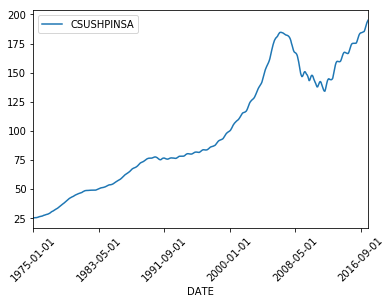

In [6]:
cshpi.plot(x='DATE',rot=45);

In [7]:
index = cshpi[cshpi['DATE']=='1978-01-01'].index[0]
index

36

In [8]:
data['MEDV-ADJ'] = np.nan

In [9]:
data['MEDV-ADJ'] = data['MEDV']*cshpi.CSUSHPINSA.iloc[-1]/cshpi.CSUSHPINSA.iloc[index]

In [10]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,MEDV-ADJ
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,141.212670
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,127.091403
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,204.169985
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,196.520965
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,212.995777


Let's split this data set into a features set and a target set.

In [11]:
prices = data['MEDV-ADJ']
features = data.drop(['MEDV', 'MEDV-ADJ'], axis = 1)

In [12]:
features.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [13]:
prices.head()

0    141.212670
1    127.091403
2    204.169985
3    196.520965
4    212.995777
Name: MEDV-ADJ, dtype: float64

The next thing to do is to look at some statistics about this data. We want to know which of these features will actually be useful in predictin the target. The idea here is that want to identify the features that are most correlated to the target, which is the home price. However, we don't want features that are highly correlated to each other - these features wind up being redundant, or worse, will reduce the predictor's ability to learn the target.

In [14]:
features.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [15]:
features.shape

(506, 13)

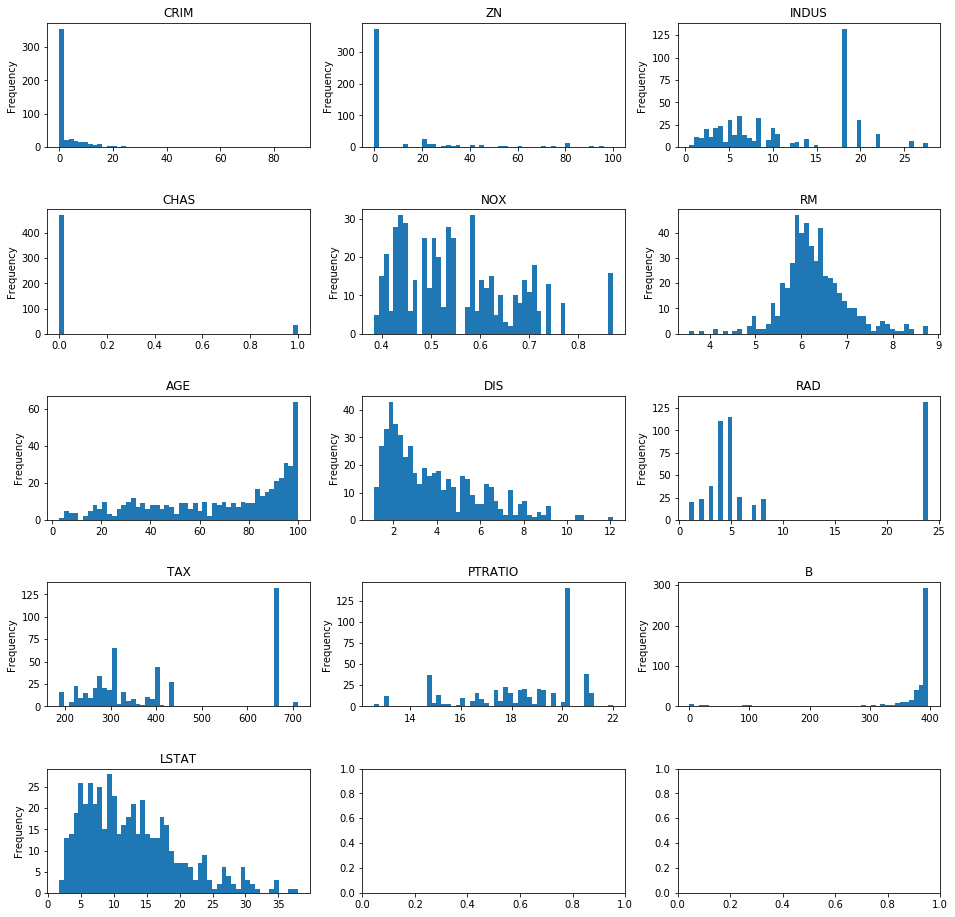

In [16]:
f, axs = plt.subplots(5,3)

plt.subplots_adjust(hspace=0.5)
#f.text(0.5, 0.04, 'Price of Houses', ha='center', fontsize=14)

for i in range(0,13):
    axs.flatten()[i].set_title(features.columns[i])
    features[features.columns[i]].plot(ax=axs.flatten()[i],kind = 'hist', bins=50, figsize=(16,16))

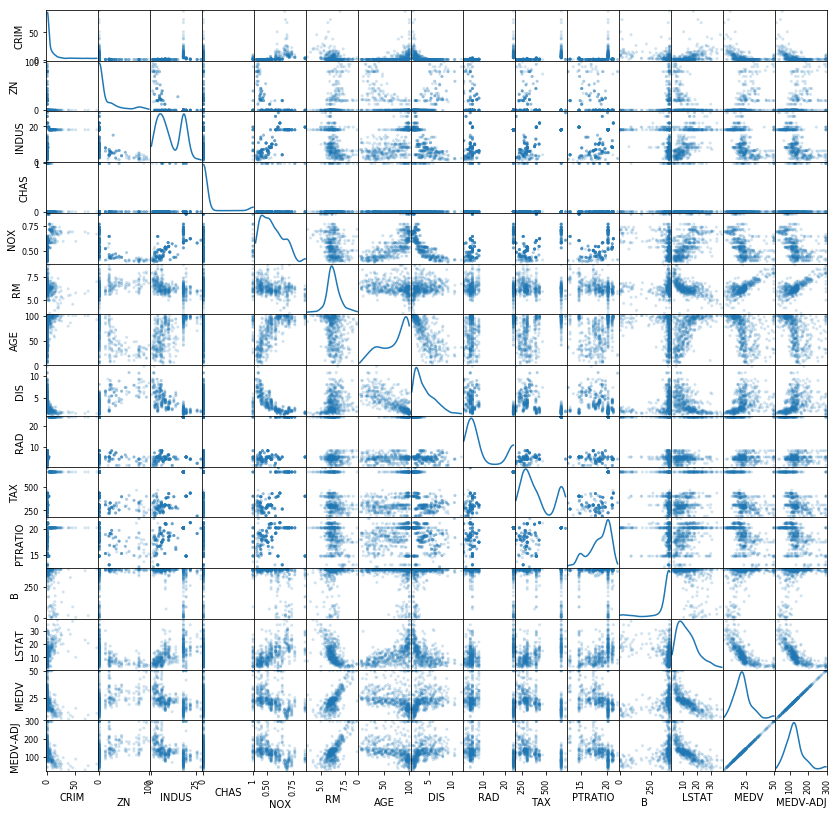

In [18]:
from pandas.plotting import scatter_matrix

scatter_matrix(data, alpha=0.2, figsize=(16, 16), diagonal='kde');

From the above scatter matrix we can quickly see that some of these features are better than others. Case in point the feature 'RM' (average number of rooms) is just about perfectly correlated with the price, which is exactly what we would expect. However, there appears to be some negative correlation with 'LSTAT'. Outside of that 'RM' looks to be fairly independent of the rest.

Not so with 'DIS' (weight distance to 5 Boston employment centers). It looks to be correlated with all except 'RAD', 'TAX', and 'PTRATIO'.

'INDUS', 'RAD', and 'TAX' are strongly bimodal. None of them appears to have any obvious correlation with price, however, so we may decide to discard them altogether.

'B', 'CRIM', and 'ZN' are all highly skewed which will need to be logged, or something else, to normalize these features.

'NOX', 'AGE', and 'PTRATION' all look to need to be rescaled.

count    506.000000
mean       3.613524
std        8.601545
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677082
max       88.976200
Name: CRIM, dtype: float64

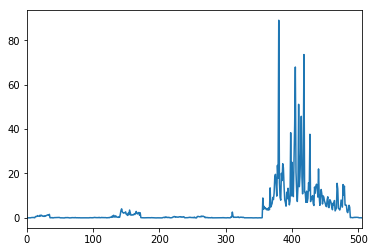

In [19]:
features['CRIM'].plot(); features['CRIM'].describe()

In [39]:
logcrim = np.log(features['CRIM'])

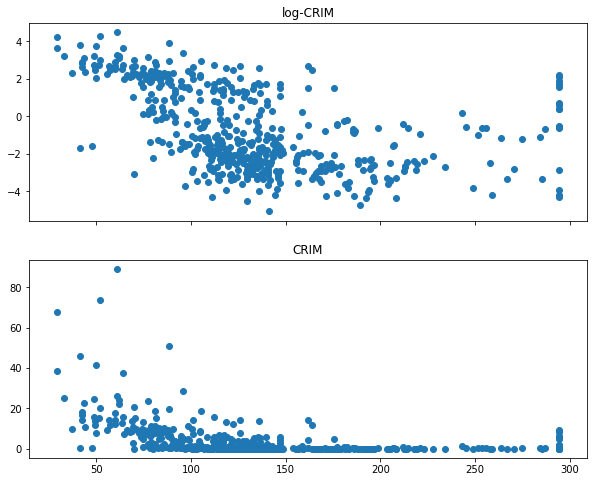

In [51]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax1.set_title('log-CRIM')
plt.scatter(prices, logcrim)
ax2 = plt.subplot(212, sharex=ax1)
ax2.set_title('CRIM')
plt.scatter(prices, features['CRIM']);
plt.setp(ax1.get_xticklabels(), visible=False);

For the purposes of this project, the following preprocessing steps have been made to the dataset:

- 16 data points have an 'MEDV' value of 50.0. These data points likely contain missing or censored values and have been removed.
- 1 data point has an 'RM' value of 8.78. This data point can be considered an outlier and has been removed.
- The features 'RM', 'LSTAT', 'PTRATIO', and 'MEDV' are essential. The remaining non-relevant features have been excluded.
- The feature 'MEDV' has been multiplicatively scaled to account for 35 years of market inflation.

## Data Exploration


The features, 'RM', 'LSTAT', and 'PTRATIO', give us quantitative information about each data point. The target variable, 'MEDV', will be the variable we seek to predict. These are stored in features and prices, respectively.

In [ ]:
# Minimum housing value in the dataset
minimum_price = np.min(prices)

# Maximum housing value in the dataset
maximum_price = np.max(prices)

# Mean house value of the dataset
mean_price = np.mean(prices)

# Median house value of the dataset
median_price = np.median(prices)

# Standard deviation of housing values of the dataset
std_price = np.std(prices)

# Show the calculated statistics
print "Boston Housing dataset statistics:\n"
print "Minimum house price:", minimum_price
print "Maximum house price:", maximum_price
print "Mean house price: {0:.3f}".format(mean_price)
print "Median house price:", median_price
print "Standard deviation of house price: {0:.3f}".format(std_price)

## Feature Analysis

I am using three features from the Boston housing dataset: 'RM', 'LSTAT', and 'PTRATIO'. For each data point (neighborhood):

- 'RM' is the average number of rooms among homes in the neighborhood.
- 'LSTAT' is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- 'PTRATIO' is the ratio of students to teachers in primary and secondary schools in the neighborhood.

With a rudimentary knowledge of housing market, I would guess that an increase in 'RM' would lead to an increase in 'MEDV'. Likewise, an increase in 'LSTAT' would lead to a decrease in 'MEDV'. Finally, an increase in 'PTRATIO' would likely see an increase in 'MEDV'.

## Developing a Model

### Implementation: Define a Performance Metric

It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, I will be calculating the coefficient of determination, R2, to quantify the model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions.

The values for R2 range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the target variable. A model with an R2 of 0 is no better than a model that always predicts the mean of the target variable, whereas a model with an R2 of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the features. A model can be given a negative R2 as well, which indicates that the model is arbitrarily worse than one that always predicts the mean of the target variable.

For the performance_metric function in the code cell below, I will implement the following:

- Use r2_score from sklearn.metrics to perform a performance calculation between y_true and y_predict.
- Assign the performance score to the score variable.

In [ ]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Goodness of Fit

Let's assume that a dataset contains five data points and a model made the following predictions for the target variable:  

|True Value      |	Prediction      |  
|:--------:      |  :--------:      |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Would this model have successfully captured the variation of the target variable? I would guess yes, because the predicted values *appear* to be pretty close to the true values.

The code cell below uses the performance_metric function and calculates this model's coefficient of determination.

In [ ]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

As you can 0.923 is pretty close to 1.0, therefore, these predicted values come from a model that would be a good predicter of the actual values.

### Implementation: Shuffle and Split the Data

The next implementation requires the Boston housing dataset be split into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, I will do the following:

- Use train_test_split from sklearn.cross_validation to shuffle and split the features and prices data into training and testing sets.
- Split the data into 80% training and 20% testing.
- Set the random_state for train_test_split. This ensures results are consistent.
- Assign the train and testing splits to X_train, X_test, y_train, and y_test.


In [ ]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size = 0.2, random_state = 0)

# Success
print "Training and testing split was successful."

I'm splitting the data so that I can evaluate whether my learner is doing a good job at predicting the outcome. To do this I need to save off a portion of the data that the learner hasn't been modelled to yet. This test data will be used to evaluate the performance of the learner that was just created to determine if any adjustments need to be made to improve performance.  

This is especially important in regards to preventing over-fitting the learner to the data. This happens when an learner does too good a job at fitting to a dataset; so good that it does poorly when provided with data that falls outside the statistics of the data that it trained on. In this case, new data outside the statistics of the training data will yield much higher prediction errors.  

To avoid this I'll split the datasets to compare the training error to the testing error so that I can find the best balance between minimizing the difference between the errors as well as minimizing the overall value of the errors.

## Analyze Model Performance

In this third section of the project, I'll take a look at a Decision Tree Regressor's learning and testing performances on various subsets of training data. Additionally, I'll investigate one particular algorithm with an increasing `max_depth` parameter on the full training set to observe how model complexity affects performance. Graphing the model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R2, the coefficient of determination.

In [ ]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(X_train, y_train)

## Learning the Data

Each graph above shows the number of training points used along the x-axis with the score for the model with that number of training points on the y-axis using the R2 coefficient of determination metric to evaluate it's performance.

In the first graph we see that the training and testing sets for a Decision Tree with a depth of 1 branch converge to an R2 of somewhere between 0.4 and 0.5. We also see that the training and testing models start converge around 50 data points for the training set. They get closest around 300 data points with a score of around 0.45. Because they converged so quickly, this tells us that there the model has high bias in that there isn't enough complexity in it to account for all of variation in the data, thus yielding a low score.

The graph to it's right shows the training and testing sets for a Decision tree with a maximum depth of 3 branches. Here we can see that the training and testing sets converge a bit more slowly, getting closest again near 300. However, the score is much higher at around 0.8. Also beyond this number of training points, we don't see much improvement. This appears to be a pretty good model in that there's enough complexity in the model to fit the data pretty closely, but not so much complexity that it can't account for large enough percentage of the data to yield a very score. This looks to be our best model so far.

Looking at the lower left graph for a Decision Tree with 6 branches we can see that the training data has a relatively high score near 0.9, but that the testing data seems to reach a limit at around 0.8. That lack of convergence indicates a high variance in the model in that it's too complex to account of data outside it's training data, yielding much higher discrepancies in it's training versus testing. This means it won't predict very well on new data. 

We can see that the high variance problem only gets worth with more branches in the final graph on the lower right.

So far, my best guess for the Decision Tree Regressor is to use 3 branches for an optimal model.

## Complexity Curves

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the learning curves, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.

In [ ]:
vs.ModelComplexity(X_train, y_train)

In the above graph we can see a validation of the Decision Tree Regressor with 4 branches as the optimal max_depth for this data set. The training and testing score curves start diverge right at a maximum depth of 4 branches.

We can also see that at lower max depths there is lower performance and convergence between the train and test sets indicating high bias. However, as the depth approaches 3 we see the performance in increasing score start slowing. After 4, with increasing complexity in the model we see the test scores start to decrease and get further away from the scores for the train scores. Beyond 4 branches we see the problem with high variance from too much model complexity where the model is over-fitting the training data and underperforming on the testing data.

## Evaluating Model Performance

In this final section of the project, I will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

For many of the models that are typically used for learning different datasets they have parameters that are internal to the models themselves that aren't directly learnt within the estimators from the datasets. Some of these models can have several hyper-parameters all of which need to be independently set to affect the performance of the model.

We'll need a methodical approach to tuning these hyper-parameters to get the best possible performance out of the learning model.

For this methodology I will use GridSearchCV along with k-folds cross-validation to scan across various ranges of hyper-parameters with varying training and testing set splits to find the best hyper-parameter settings to get the best results.

When evaluating different settings (“hyperparameters”) for estimators, such as the max_depth for the Decision Tree Regressor, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets. The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute the performance measure R2).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data.

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    max_depth = np.arange(1,11)
    params = {'max_depth': max_depth}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, param_grid = params, cv = cv, scoring = scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

## Making Predictions

Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a decision tree regressor, the model has learned what the best questions to ask about the input data are, and can respond with a prediction for the target variable. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.


## Optimal Model

In [ ]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

## Predicting Selling Prices

Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature 	| Client 1 	| Client 2  	| Client 3      |
| :-----:   | :------:  | :------:      | :------:      |
|Total number of rooms in home 	| 5 rooms |	4 rooms |	8 rooms |
|Neighborhood poverty level (as %) 	| 17% |	32% |	3% |
|Student-teacher ratio of nearby schools 	| 15-to-1 |	22-to-1 |	12-to-1 |

What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?

In [ ]:
pred = reg.predict(X_test)
score = performance_metric(pred,y_test)
print "R^2 score for test data set: {:.4f}".format(score)

In [ ]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
pred = reg.predict(client_data)
for i, price in enumerate(pred):
    #print performance_metric(pred[i])
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

From the test data above, we can see that the house with the most number of rooms, the least amount of surrounding poverty and the lowest student-teacher ratio should have the highest price, which it does.

Conversely, the house with the least rooms, highest neighborhood poverty and highest student-teacher ration should have the lowest price, again confirmed.

The above results match our training data intuitions quite well, and confirms that relatively speaking we can expect useful results from this predictor.

## Sensitivity

An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. The code cell below will run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [ ]:
vs.PredictTrials(features, prices, fit_model, client_data)

## Applicability

- How relevant today is data that was collected from 1978?
- Are the features present in the data sufficient to describe a home?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?

Questions like these are highly relevant to doing this type of analysis. Housing markets are extremely flexible and subject to quite a lot of variation over time that may not reflect underlying inflation in the broader economy, which is the assumption that was used to change the `MEDV`prices to reflect today's housing prices in the Boston area. So it's very likely that this data wouldn't be very robust to today's housing market in the Boston area.

Addionally, the are almost certainly other features of a house that should intuitively be more predictive of a house's value like square footage, number of bathrooms, proximity to waterfronts, number of levels, etc.

However, given those limitations, this does appear to give us a good process by which we can find good predictions with a bit more data that has more features that was more recently collected.

Finally, housing markets vary in the US quite a lot from region to region. So we should expect our model to only be predictive in the region that we modelled on.